## Setup

In [1]:
import sys
from _path import workdir
sys.path.append(workdir)
print(sys.path)

['c:\\Users\\vince\\AppData\\Local\\anaconda3\\envs\\phys\\python312.zip', 'c:\\Users\\vince\\AppData\\Local\\anaconda3\\envs\\phys\\DLLs', 'c:\\Users\\vince\\AppData\\Local\\anaconda3\\envs\\phys\\Lib', 'c:\\Users\\vince\\AppData\\Local\\anaconda3\\envs\\phys', '', 'c:\\Users\\vince\\AppData\\Local\\anaconda3\\envs\\phys\\Lib\\site-packages', 'c:\\Users\\vince\\AppData\\Local\\anaconda3\\envs\\phys\\Lib\\site-packages\\win32', 'c:\\Users\\vince\\AppData\\Local\\anaconda3\\envs\\phys\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\vince\\AppData\\Local\\anaconda3\\envs\\phys\\Lib\\site-packages\\Pythonwin', 'c:\\Users\\vince\\OneDrive - The Chinese University of Hong Kong\\python projects\\py binary orbit\\paper_QPE2005\\..']


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LogLocator
from scipy.optimize import root_scalar
import scienceplots

from src.util.constants import G, msun, c
from src.orbit.empirical.WDBH_EMRI import rWD, rtide, wf, olapf
from src.orbit.mapping.simple_map import s_dq
from src.orbit.mapping.single_mode.WD_MBH import s_map_WDBH_MT_expo
from src.orbit.osculating.orb_avg_formula import de_2_5pn, dP_2_5pn

## Calculate

### Parameters

In [3]:
mWD = 0.5*msun
mBH = 1e5*msun
rt = rtide(mWD,mBH)

w_list1, olap_list1, ell_list1, m_list1 = [wf(mWD)], [olapf(mWD,0.5)], [2], [2]
w_list2, olap_list2, ell_list2, m_list2 = [], [], [], []

m1, r1 = mWD, rWD(mWD)
m2, r2 = mBH, 2*G*mBH/c**2

q10 = np.zeros(len(w_list1)*len(ell_list1)*len(m_list1))
q20 = np.zeros(len(w_list2)*len(ell_list2)*len(m_list2))

In [4]:
Torb = 9.*3600
a0 = (G*(mBH+mWD)*(Torb/2/np.pi)**2)**(1./3)

In [5]:
rp_list = np.linspace(1.5,5.,80)*rt
sigma_list = np.logspace(-5, -1, 40)
# alpha = 1.
alpha = 1.43

In [6]:
def max_n(m1,m2,rp,a0,ef):
    e0 = 1 - rp/a0
    P0K = 2*np.pi*np.sqrt(a0**3/G/(m1+m2))
    nf = (ef-e0)/de_2_5pn(m1,m2,a0,e0)/P0K
    return int(nf)

In [7]:
Lacc_required = 1.e44
Lacc_eff = 0.1

def P_min(rp):
    return 2*np.pi*rp**3/np.sqrt(G*m2*(2*r1)**3)

def find_Lacc(m1,m2,a,e,sigma):
    rp = np.abs(a*(1-e))
    ga = np.exp(2.-rp/rtide(m1,m2))
    ga = np.where(np.exp(2.-rp/rtide(m1,m2)) < 1., np.exp(2.-rp/rtide(m1,m2)), 1.)
    return sigma*m1*c**2/P_min(rp)/3 * ga *Lacc_eff

In [8]:
def search_threshold(list, acc = True):
    for idx in range(len(list)-2, -1, -1):
        if acc:
            if list[idx]< 0. and list[idx+1] >= 0.:
                break
        else:
            if list[idx]> 0. and list[idx+1] <= 0.:
                break
    return idx

### 2D map

In [9]:
def find_rp_max_chaos(a,m1,m2,w):
    def _func(rp):
        e = 1 - rp/a
        P0K = 2*np.pi*np.sqrt(a**3/G/(m1+m2))
        n_cir = -0.1/de_2_5pn(m1,m2,a,e)/P0K
        n_res = -2*np.pi/w/dP_2_5pn(m1,m2,a,e)/P0K
        return n_res - n_cir
    return root_scalar(_func, x0= 100.*rt).root
rp_max_chaos = find_rp_max_chaos(a0, m1,m2,w_list1[0])
e0 = 1-5*rt/a0
print(rp_max_chaos/rt)
print((-0.1/de_2_5pn(m1,m2,a0,e0))/(-2*np.pi/w_list1[0]/dP_2_5pn(m1,m2,a0,e0)))
print(0.1/2/np.pi*w_list1[0]*Torb*18./19/e0/(1-e0**2)*(1+73/24*e0**2+37/96*e0**4)/(1+121/304*e0**2))
print(w_list1[0]*Torb)
print(2*np.pi/w_list1[0]/dP_2_5pn(m1,m2,a0,e0)/Torb)
print(w_list1[0]*dP_2_5pn(m1,m2,a0,e0)*Torb)


5.25948988265289e-07
6110.895298391372
6110.895298391443
11081.921276736293
-214.35238227717076
-0.02931241183526966


c:\Users\vince\AppData\Local\anaconda3\envs\phys\Lib\site-packages\scipy\optimize\_root_scalar.py:315: RuntimeWarning: Derivative was zero.
  r, sol = methodc(f, x0, args=args, fprime=fprime, fprime2=None,


In [48]:
def find_rp_break(a,m1,m2,w,olap):
    def _func(rp):
        e = 1 - rp/a
        P0K = 2*np.pi*np.sqrt(a**3/G/(m1+m2))
        n_cir = -0.1/de_2_5pn(m1,m2,a,e)/P0K
        return 0.1/n_cir/np.abs(s_dq(m1,m2,r1,w,olap,rp))**2 - 1.
    return root_scalar(_func, x0= 4.*rt).root
    
rp_break = find_rp_break(a0, m1,m2,w_list1[0],olap_list1[0])

In [49]:
print(rp_break/rt)

3.738349803762452


In [50]:
def find_rp_chaos(a,m1,m2,w,olap):
    def _func(rp):
        e = 1 - rp/a
        P0K = 2*np.pi*np.sqrt(a**3/G/(m1+m2))
        n_cir = -0.1/de_2_5pn(m1,m2,a,e)/P0K
        emode = n_cir*G*(m1/m2)*(m1+m2)/r1*np.abs(s_dq(m1,m2,r1,w,olap,rp))**2
        dP = 1.5*emode/(G*(m1+m2)/2/a)*P0K
        f_resolution = 1./4/31536000
        P_resolution = f_resolution*P0K**2
        return dP - P_resolution
    return root_scalar(_func, x0= 4.*rt).root

rp_chaos = find_rp_chaos(a0,m1,m2,w_list1[0],olap_list1[0])

In [51]:
print(rp_chaos/rt)

4.24865373206773


In [52]:
def find_sig_unbind(a,m1,m2,w,olap,rp, alp):
    def _func(sig):
        e = 1 - rp/a
        P0K = 2*np.pi*np.sqrt(a**3/G/(m1+m2))
        return 0.1/np.abs(s_dq(m1,m2,r1,w,olap,rp))**2*de_2_5pn(m1,m2,a,e) + 4*sig*np.exp(alp*(2-rp/rt))
    return root_scalar(_func, x0= 1.e-3).root

sig_unbind = np.array(list(map(lambda rp: find_sig_unbind(a0, m1,m2,w_list1[0],olap_list1[0], rp, 1.0), rp_list)))

In [53]:
print(sig_unbind)

[9.00842213e-12 1.03619597e-11 1.20054822e-11 1.40067756e-11
 1.64514356e-11 1.94478467e-11 2.31336534e-11 2.76841925e-11
 3.33235091e-11 4.03387888e-11 4.90993164e-11 6.00814511e-11
 7.39016179e-11 9.13600090e-11 1.13498633e-10 1.41678633e-10
 1.77683558e-10 2.23857660e-10 2.83291627e-10 3.60072665e-10
 4.59622153e-10 5.89152735e-10 7.58288770e-10 9.79910704e-10
 1.27130724e-09 1.65575160e-09 2.16466353e-09 2.84058245e-09
 3.74126651e-09 4.94535830e-09 6.56023590e-09 8.73291953e-09
 1.16652610e-08 1.56351501e-08 2.10261953e-08 2.83693661e-08
 3.84015615e-08 5.21481840e-08 7.10398380e-08 9.70776529e-08
 1.33068046e-07 1.82956885e-07 2.52306248e-07 3.48976242e-07
 4.84102311e-07 6.73499376e-07 9.39683819e-07 1.31479185e-06
 1.84480117e-06 2.59565183e-06 3.66214042e-06 5.18087326e-06
 7.34917253e-06 1.04527323e-05 1.49061622e-05 2.13125552e-05
 3.05511933e-05 4.39069641e-05 6.32617318e-05 9.13779271e-05
 1.32319683e-04 1.92079549e-04 2.79513098e-04 4.07735581e-04
 5.96213404e-04 8.739025

In [54]:
# RL overflow
eta_min = np.empty_like(rp_list)
rp_RL = np.empty_like(sigma_list)
rp_RL27 = np.empty_like(sigma_list)
# Unbinding the orbit
e_max = np.empty_like(rp_list)
rp_e = np.empty_like(sigma_list)
# Luminosity
L_max = np.empty_like(rp_list)
rp_L = np.empty_like(sigma_list)
sigma_grid_2d = np.zeros(shape=(len(sigma_list),len(rp_list)))
rp_grid_2d = np.zeros(shape=(len(sigma_list),len(rp_list)))
eta_min_2d = np.zeros(shape=(len(sigma_list),len(rp_list)))
e_min_2d = np.zeros(shape=(len(sigma_list),len(rp_list)))

for isig, sig in enumerate(sigma_list):
    for irp, rp in enumerate(rp_list):

        if rp >= rp_break:
            ntot = max_n(m1,m2,rp,a0,0.9)
        else:
            # ntot = int(max_n(m1,m2,rp,a0,0.9)*6.5)
            ntot = int(max_n(m1,m2,rp,a0,0.5)*7.5)

        # Find rp for Roche lobe overflow
        qn, an, en, m1n, m2n = s_map_WDBH_MT_expo(m1,m2,w_list1[0],olap_list1[0],q10[0],a0 = a0\
                                                ,rp= rp,sigma = sig,ga = 1.,mu1 = 1., ntot=ntot, alpha = alpha\
                                                , q_break= 0.0316, m1_min = 0.1, flag_vary_rp = True)
        eta_min[irp] = np.min(an*(1-en)/rtide(m1n,m2n))
        e_max[irp] = np.max(en)
        L_max[irp] = np.max(find_Lacc(m1n,m2n,an,en,sig))

        sigma_grid_2d[isig,irp] = sig
        rp_grid_2d[isig,irp] = rp
        eta_min_2d[isig,irp] = np.min(an*(1-en)/rtide(m1n,m2n))
        e_min_2d[isig,irp] = np.min(en)
        
    rp_RL[isig] = rp_list[search_threshold(eta_min-2.)]
    rp_RL27[isig] = rp_list[search_threshold(eta_min-2.7)]
    rp_e[isig] = rp_list[search_threshold(e_max-1., acc = False)]
    rp_L[isig] = rp_list[np.argmin(np.abs(L_max-Lacc_required))]


KeyboardInterrupt: 

In [ ]:
# Fitting
coef_RL = np.polyfit(np.log10(sigma_list), rp_RL, 6)
fit_RL= np.poly1d(coef_RL)
coef_RL27 = np.polyfit(np.log10(sigma_list[0:20]), rp_RL27[0:20], 4)
fit_RL27= np.poly1d(coef_RL27)
coef_e = np.polyfit(np.log10(sigma_list[5:]), rp_e[5:], 4)
fit_e= np.poly1d(coef_e)
coef_Lacc = np.polyfit(np.log10(sigma_list[6:-12]), rp_L[6:-12], 2)
fit_Lacc= np.poly1d(coef_Lacc)

In [ ]:
sigma_read_rpmap, rp_read_rpmap = np.loadtxt('data_plot_2d_map_rp_sigma/2d_rp_contour_alpha143.txt',unpack=True)
sigma_read_emap, rp_read_emap = np.loadtxt('data_plot_2d_map_rp_sigma/2d_e_contour_alpha143.txt',unpack=True)

### Test

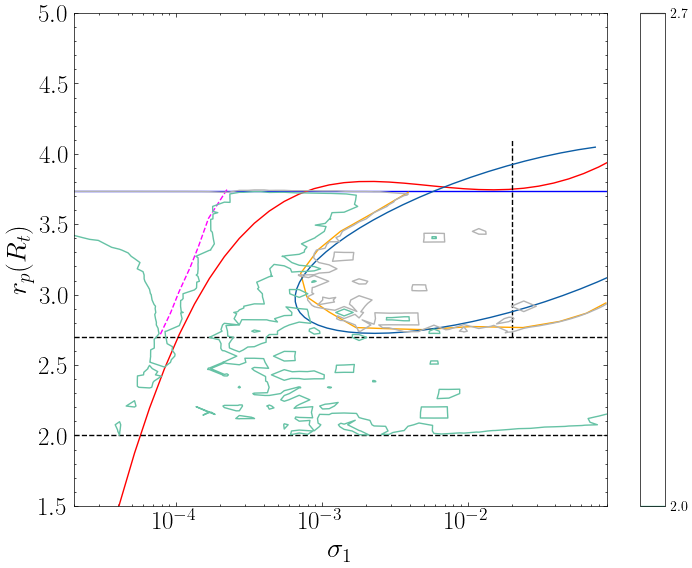

In [ ]:
RL_xrange = [2.e-2, 2.e-2]
RL_yrange = [2.7, 4.1]

x = sigma_grid_2d.flatten()
y = rp_grid_2d.flatten()/rt
z = eta_min_2d.flatten()

a = 1.55
b = 0.5
tilt = np.pi/10
u_list = np.linspace(0.34*np.pi, 1.65*np.pi)
x_ellipse = 10**(a*np.cos(u_list)*np.cos(tilt) - b*np.sin(u_list)*np.sin(tilt)-1.7)
y_ellipse = a*np.cos(u_list)*np.sin(tilt) + b*np.sin(u_list)*np.cos(tilt) + 3.4

plt.figure(figsize=(8.6,6.4), dpi= 100)
plt.style.use('science')

plt.axhline(rp_break/rt, color = 'blue', linestyle = 'solid')

# plt.plot(sigma_list, rp_RL/rt, 'orange', marker = '.', linestyle = '')
# plt.plot(sigma_list, fit_RL(np.log10(sigma_list))/rt, 'orange', linestyle = 'solid')
# plt.plot(sigma_list[0:20], fit_RL27(np.log10(sigma_list[0:20]))/rt, 'orange', linestyle = 'solid')
# plt.plot(sigma_list, rp_L/rt, 'gray', marker = '.', linestyle = '')
# plt.plot(sigma_list[:-12], fit_Lacc(np.log10(sigma_list[:-12]))/rt, 'gray', linestyle = 'solid')
# plt.plot(sigma_list, rp_e/rt, 'r', marker = 'x', linestyle = '')
plt.plot(sigma_list, fit_e(np.log10(sigma_list))/rt, 'r', linestyle = 'solid')

plt.plot(RL_xrange,RL_yrange, color = 'black', linestyle = 'dashed')
plt.axhline(2., color = 'black', linestyle = 'dashed')
plt.axhline(2.7, color = 'black', linestyle = 'dashed')

plt.plot(sigma_read_rpmap, rp_read_rpmap, color = 'orange', linestyle = 'solid')
plt.plot(sigma_read_emap, rp_read_emap, color = 'magenta', linestyle = 'dashed')

plt.plot(x_ellipse,y_ellipse)
plt.tricontour(x,y,z, cmap=cm.Set2, levels=[2., 2.7])
plt.colorbar()

plt.xlabel(r'$\sigma_1$',fontsize=20)
plt.ylabel(r'$r_p (R_t)$',fontsize=20)
plt.xlim([sigma_list[0]*2,sigma_list[-1]*0.9])
plt.ylim([rp_list[0]/rt,rp_list[-1]/rt])
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xscale('log')

plt.show()
plt.close()

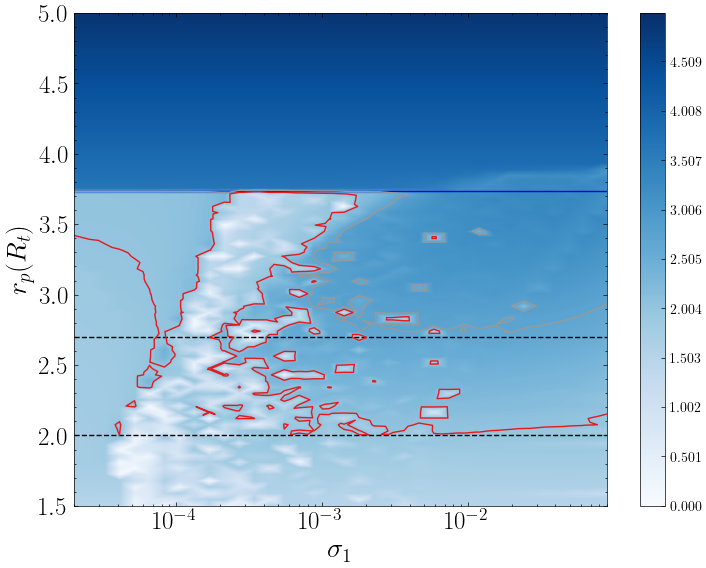

In [ ]:
x = sigma_grid_2d.flatten()
y = rp_grid_2d.flatten()/rt
z = eta_min_2d.flatten()

plt.figure(figsize=(8.6,6.4), dpi= 100)
plt.style.use('science')

plt.axhline(rp_break/rt, color = 'blue', linestyle = 'solid')

plt.axhline(2., color = 'black', linestyle = 'dashed')
plt.axhline(2.7, color = 'black', linestyle = 'dashed')

# plt.plot(sigma_read, rp_read, color = 'orange', linestyle = 'solid')

levels_list = np.linspace(0., 5., 500)
plt.tricontour(x,y,z, cmap=cm.Set1, levels=[2., 2.7])
plt.tricontourf(x,y,z, cmap=cm.Blues, levels=levels_list)
plt.colorbar()

plt.xlabel(r'$\sigma_1$',fontsize=20)
plt.ylabel(r'$r_p (R_t)$',fontsize=20)
plt.xlim([sigma_list[0]*2,sigma_list[-1]*0.9])
plt.ylim([rp_list[0]/rt,rp_list[-1]/rt])
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xscale('log')

plt.show()
plt.close()

In [ ]:
# i1, i2 = 13, 16
# print(sigma_grid_2d[i1,i2])
# print(rp_grid_2d[i1,i2]/rt)
# print(eta_min_2d[i1,i2])

# rpt = rp_grid_2d[i1,i2]
# sigt = sigma_grid_2d[i1,i2]
# ntott = int(max_n(m1,m2,rp_grid_2d[i1,i2],a0,0.5)*7.5)
# qnt, ant, ent, m1nt, m2nt = s_map_WDBH_MT_expo(m1,m2,w_list1[0],olap_list1[0],q10[0],a0 = a0\
#                                                 ,rp= rpt,sigma = sigt,ga = 1.,mu1 = 1., ntot=ntott, alpha = alpha\
#                                                 , q_break= 0.0316, m1_min = 0.1, flag_vary_rp = True)
# print(m1,m2,w_list1[0],olap_list1[0],q10[0],a0,rpt,sigt,1.,1.,ntott,alpha)
# print(9.94275e+32,1.98855e+38,0.34203460730667573,0.14211078499977345,0.0,7066834133433.972,118024873233.01358,5.2233450742668436e-05,1.0,1.0,4182247,1.43)

# print(np.min(ant*(1-ent)/rtide(m1nt,m2nt)))

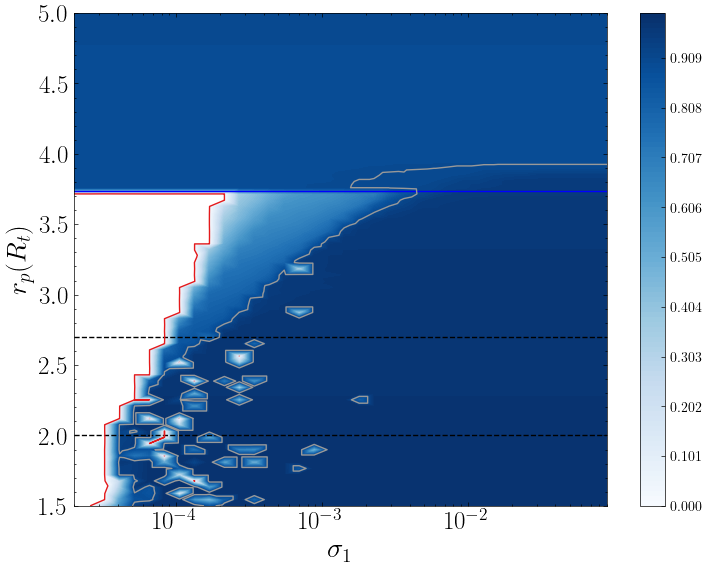

In [ ]:
x = sigma_grid_2d.flatten()
y = rp_grid_2d.flatten()/rt
z = e_min_2d.flatten()

plt.figure(figsize=(8.6,6.4), dpi= 100)
plt.style.use('science')

plt.axhline(rp_break/rt, color = 'blue', linestyle = 'solid')

plt.axhline(2., color = 'black', linestyle = 'dashed')
plt.axhline(2.7, color = 'black', linestyle = 'dashed')

levels_list = np.linspace(0., 1., 100)
plt.tricontour(x,y,z, cmap=cm.Set1, levels=[0., 0.9])
plt.tricontourf(x,y,z, cmap=cm.Blues, levels=levels_list)
plt.colorbar()

plt.xlabel(r'$\sigma_1$',fontsize=20)
plt.ylabel(r'$r_p (R_t)$',fontsize=20)
plt.xlim([sigma_list[0]*2,sigma_list[-1]*0.9])
plt.ylim([rp_list[0]/rt,rp_list[-1]/rt])
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xscale('log')

plt.show()
plt.close()

### output

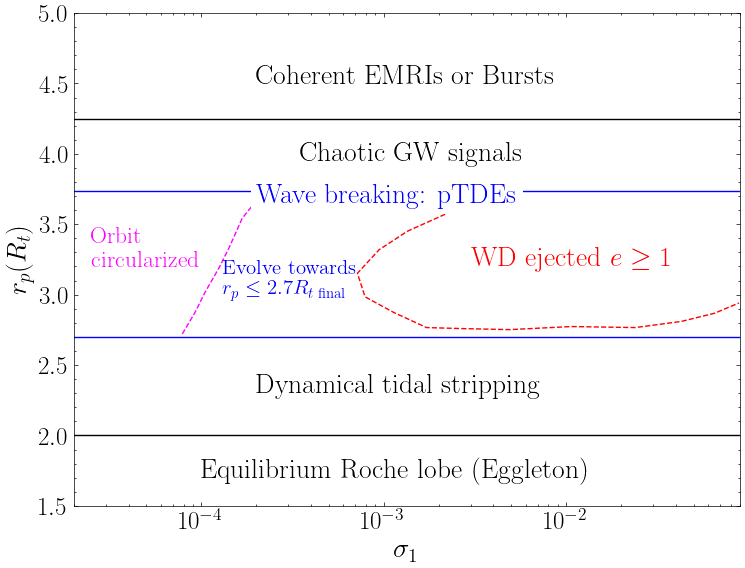

In [ ]:
x = sigma_grid_2d.flatten()
y = rp_grid_2d.flatten()/rt
z = eta_min_2d.flatten()

a = 1.55
b = 0.5
tilt = np.pi/10
u_list = np.linspace(0.34*np.pi, 1.65*np.pi)
x_ellipse = 10**(a*np.cos(u_list)*np.cos(tilt) - b*np.sin(u_list)*np.sin(tilt)-1.7)
y_ellipse = a*np.cos(u_list)*np.sin(tilt) + b*np.sin(u_list)*np.cos(tilt) + 3.4

plt.figure(figsize=(8.6,6.4), dpi= 100)
plt.style.use('science')

plt.axhline(rp_break/rt, color = 'blue', linestyle = 'solid')

plt.axhline(rp_chaos/rt, color = 'black', linestyle = 'solid')
plt.axhline(2., color = 'black', linestyle = 'solid')
plt.axhline(2.7, color = 'blue', linestyle = 'solid')

# plt.plot(x_ellipse,y_ellipse, 'r', linestyle = 'solid')
plt.plot(sigma_read_rpmap, rp_read_rpmap, color = 'red', linestyle = 'dashed')
plt.plot(sigma_read_emap, rp_read_emap, color = 'magenta', linestyle = 'dashed')

plt.xlabel(r'$\sigma_1$',fontsize=20)
plt.ylabel(r'$r_p (R_t)$',fontsize=20)
plt.xlim([sigma_list[0]*2,sigma_list[-1]*0.9])
plt.ylim([rp_list[0]/rt,rp_list[-1]/rt])
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xscale('log')

plt.text(2.e-4, 4.5, r'Coherent EMRIs or Bursts', color = 'black', fontsize = 20)
plt.text(3.5e-4, 3.95, r'Chaotic GW signals', color = 'black', fontsize = 20)
plt.text(2.e-4, 3.65, r'Wave breaking: pTDEs', color = 'blue', fontsize = 20 \
        ,bbox=dict(facecolor='white', edgecolor='none'))
plt.text(2.5e-5, 3.2, 'Orbit \n circularized', color = 'magenta', fontsize = 17)
plt.text(1.3e-4, 3., 'Evolve towards \n' +r'$r_p \leq 2.7 R_{t \text{ final}}$', color = 'blue', fontsize = 15)
plt.text(3.e-3, 3.2, r'WD ejected $e\geq 1$', color = 'red', fontsize = 20)
plt.text(1.5e-4, 2.3, r'Dynamical tidal stripping: QPEs (?)', color = 'black', fontsize = 20)
plt.text(1.e-4, 1.7, r'Equilibrium Roche lobe (Eggleton)', color = 'black', fontsize = 20)

plt.savefig("par_space_rp_sigma1.pdf", format="pdf")
plt.show()
plt.close()